<a href="https://colab.research.google.com/github/BernabeUlloa/MarketResearchShannon/blob/main/Challengue_JavierUlloa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Development of Problem Proposed by Datawheel
### By Javier Ulloa G. | jb.ulloa.garrido@gmail.com

The project primarily involves working with two Puma datasets containing information about workers in the United States. The main objectives are:

- Handling plain text data.
- Creating a new file that includes information about the highest-paid occupations in each location, their average local and national salaries.
- Visualizing relevant information.

Additionally, a section of the code is included for converting salaries from USD to Chilean Pesos (CLP) and for calculating Shannon entropy.

The work followed these approaches:

- Given the nature of the task, the focus was on identifying occupations of interest for a hypothetical client, considering a scenario where they are applying for a position within the company.
Computational efficiency was considered, although further optimization is possible.
- The workflow was kept simple for readability and reusability of certain parts of the code.

The requested file is **output.csv**


In [1]:
!pip install pygris
!pip install plotly-geo==1.0.0
!pip install geopandas==0.10
!pip install pyshp==2.1.2
!pip install shapely==1.8.4

In [2]:
import timeit
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.figure_factory as ff
import plotly.express as px

import re
from pygris.utils import shift_geometry
import geopandas
from geopandas.tools import sjoin
import pygris

### Manejo de texto plano y generacion de archivo solicitado

In [3]:
pumas_df = pd.read_csv("pumas_occupations_num_employees.csv")
print("Data info: pumas_occupations_num_employees.csv \n")
print(pumas_df.dtypes)
pumas_df.head()

Data info: pumas_occupations_num_employees.csv 

puma_id              object
puma_name            object
occupation_id        object
occupation_name      object
total_population      int64
average_wage        float64
dtype: object


,puma_id,puma_name,occupation_id,occupation_name,total_population,average_wage
0,79500US1205701,"Tampa City (Central) PUMA, FL",111021,General & operations managers,303,216321.300330
1,79500US1205701,"Tampa City (Central) PUMA, FL",1110XX,Chief executives & legislators,240,15787.429167
2,79500US1205701,"Tampa City (Central) PUMA, FL",112021,Marketing managers,219,44594.771689
3,79500US1205701,"Tampa City (Central) PUMA, FL",112022,Sales managers,427,77892.215457
4,79500US1205701,"Tampa City (Central) PUMA, FL",113012,Administrative services managers,153,30392.915033


In [4]:
occupations_df = pd.read_csv("occupations_avg_wage.csv")
print("Data info: occupations_avg_wage.csv \n")
print(occupations_df.dtypes)
occupations_df.head()

Data info: occupations_avg_wage.csv 

ID Detailed Occupation     object
Detailed Occupation        object
Average Wage              float64
dtype: object


,ID Detailed Occupation,Detailed Occupation,Average Wage
0,111021,General & operations managers,78932.012723
1,1110XX,Chief executives & legislators,141283.836459
2,112011,Advertising & promotions managers,68524.377437
3,112020,Marketing & sales managers,88388.284736
4,112021,Marketing managers,84553.351153


In [7]:
def process_data_optimized():
    #Calculation of average wages by location
    avg_salary_by_location = (
        pumas_df.groupby('puma_name')['average_wage']
        .mean()
        .reset_index()
        .rename(columns={'average_wage': 'location_avg_salary'})
    )
    #Identification of the highest-paid occupation
    highest_paid = (
        pumas_df.loc[pumas_df.groupby('puma_name')['average_wage'].idxmax()]
        [['puma_name', 'occupation_name', 'occupation_id','average_wage', 'total_population']]
        .rename(columns={
            'occupation_name': 'highest_paid_occupation',
            'average_wage': 'highest_local_avg_salary'
        })
    )
    #Calculation of total population by occupation (useful later)
    total_p_by_location = (
        pumas_df.groupby('puma_name')['total_population']
        .sum()
        .reset_index()
        .rename(columns={'total_population': 'local_total_population'})
    )
    #Highest-paid occupations at the national level
    highest_paid = highest_paid.merge(
        occupations_df[['ID Detailed Occupation', 'Average Wage']],
        left_on='occupation_id',
        right_on='ID Detailed Occupation',
        how='left'
    ).rename(columns={'Average Wage': 'national_avg_salary'}).drop(columns=['ID Detailed Occupation'])

    final_df = pd.merge(avg_salary_by_location, highest_paid, on='puma_name')
    final_df = pd.merge(final_df, total_p_by_location, on='puma_name')
    final_df = final_df.sort_values(by='location_avg_salary', ascending=False)

    return final_df

In [8]:
%%timeit
final_df = process_data_optimized()

338 ms ± 50.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
final_df = process_data_optimized()
df = final_df.drop(columns=['occupation_id',
                            'total_population',
                            'local_total_population']) #No requested
df.to_csv("output.csv", index=False)                   #RESULTS
df.head()

,puma_name,location_avg_salary,highest_paid_occupation,highest_local_avg_salary,national_avg_salary
1014,"Inner Mission & Castro PUMA, CA",96420.973134,Surgeons,572399.815668,282720.324022
120,"Battery Park City, Greenwich Village & Soho PU...",94839.246750,Dentists,668644.000000,127707.800538
375,"Chelsea, Clinton & Midtown Business District P...",91590.648998,Other financial specialists,668644.026490,98080.728621
512,"Cupertino, Saratoga Cities & Los Gatos Town PU...",85380.084584,Industrial production managers,572399.803279,77305.982431
683,"Essex County (Northwest) PUMA, NJ",84129.644104,Insurance sales agents,645342.838710,53854.686494


### Figure 1: States with the Highest-Paid Occupations
The purpose of this first figure is to identify the states where the highest-paid occupations are located. Each state contains different locations with varying highest-paid occupations, but this information was averaged here to provide a general overview. Later, our client inquires about converting salaries to Chilean pesos; perhaps they are Chilean and consider Puerto Rico a good option for work due to the shared language. However, while it may have other advantages, high salaries are not its strength. Generally, the larger states on both coasts, such as California or New York, represent the best options. Alaska, likely due to its more extreme conditions, also offers higher salaries.

In [10]:
#Extraction of state from location
def state_abbreviation(puma_name):
    match = re.search(r'PUMA,\s([A-Z]{2})', puma_name)
    if match:
        return match.group(1)
    return None

final_df['state_abbr'] = final_df['puma_name'].apply(state_abbreviation)

In [11]:
#Average wages by state
state_avg_salary = final_df.groupby('state_abbr')['location_avg_salary'].mean().reset_index()
state_avg_salary.rename(columns={'location_avg_salary': 'avg_salary'}, inplace=True)
state_values_abbr = state_avg_salary.set_index('state_abbr')['avg_salary'].to_dict()

In [12]:
#Repository with a list of states and their abbreviations
states_df = pd.read_csv("https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv")
#Usually some states are included so they are added manually
new_rows = pd.DataFrame([{'State': 'Puerto Rico', 'Abbreviation': 'PR'},
                        {'State': 'District of Columbia', 'Abbreviation': 'DC'}])
states_df = pd.concat([states_df, new_rows], ignore_index=True)

state_abbr_to_name = dict(zip(states_df['Abbreviation'], states_df['State']))
state_values_name = {state_abbr_to_name.get(abbr, abbr): salary
                        for abbr, salary in state_values_abbr.items()}


Using the default year of 2021


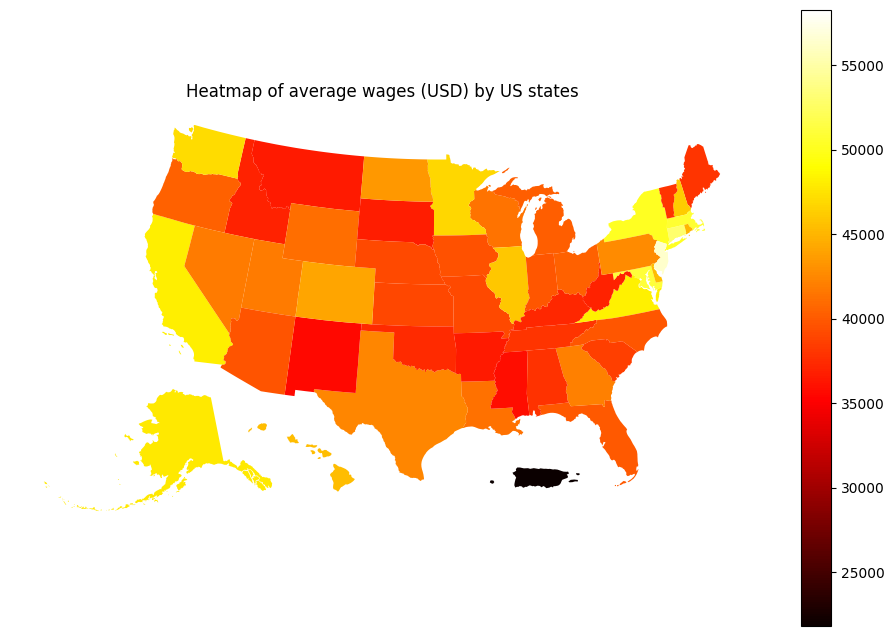

In [13]:
us = pygris.states(cb = True, resolution = "20m")
us_rescaled = shift_geometry(us)
us_rescaled['values'] = us_rescaled['NAME'].map(state_values_name)
ax = us_rescaled.plot(column='values', cmap='hot', legend=True, figsize=(12, 8))
plt.title('Heatmap of average wages (USD) by US states')
ax.set_axis_off()
plt.show()

### From US Dollars to Chilean Pesos
The following section complements the generated information by converting the currency from United States dollars (USD) to Chilean pesos (CLP) for each money-related column in our dataframe. For this purpose, the data available on the [Chilean Internal Revenue Service](https://www.sii.cl/valores_y_fechas/dolar/dolar2022.htm ) (SII) website is used. The **December 2022** average is considered; however, it is possible to adjust both the month and year to obtain values based on specific requirements, thanks to the web scraping approach implemented in the code.

In [14]:
import requests
from bs4 import BeautifulSoup

def average_dollar_f(year, month):
    url = f"https://www.sii.cl/valores_y_fechas/dolar/dolar{year}.htm"
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")

    element_strong = soup.find_all('strong')

    for element in element_strong:
        if f"Promedio {month}" in element.text:
            txt = element.text
            dollar_v = txt.split(":")[1].strip().replace("$", "").replace(",", ".")
            return float(dollar_v)
    return None

In [15]:
# Example: December average for 2022
year = 2022
month = "Diciembre"
average_dollar = average_dollar_f(year, month)
print(average_dollar)

875.66


In [16]:
# Function to convert to CLP
def dollar2peso(clp, usd):
    return clp * usd

In [17]:
if average_dollar:
    # Convert relevant columns to CLP
    final_df['location_avg_salary_CLP'] = final_df['location_avg_salary'].apply(lambda x: dollar2peso(x, average_dollar))
    final_df['highest_local_avg_salary_CLP'] = final_df['highest_local_avg_salary'].apply(lambda x: dollar2peso(x, average_dollar))
    final_df['national_avg_salary_CLP'] = final_df['national_avg_salary'].apply(lambda x: dollar2peso(x, average_dollar))
    final_df.to_csv("output_CLP.csv", index=False) #RESULTS + CLP


In [18]:
final_df.head()

,puma_name,location_avg_salary,highest_paid_occupation,occupation_id,highest_local_avg_salary,total_population,national_avg_salary,local_total_population,state_abbr,location_avg_salary_CLP,highest_local_avg_salary_CLP,national_avg_salary_CLP
1014,"Inner Mission & Castro PUMA, CA",96420.973134,Surgeons,291240,572399.815668,217,282720.324022,87988,CA,8.443199e+07,5.012276e+08,2.475669e+08
120,"Battery Park City, Greenwich Village & Soho PU...",94839.246750,Dentists,291020,668644.000000,220,127707.800538,111667,NY,8.304693e+07,5.855048e+08,1.118286e+08
375,"Chelsea, Clinton & Midtown Business District P...",91590.648998,Other financial specialists,1320XX,668644.026490,151,98080.728621,123125,NY,8.020227e+07,5.855048e+08,8.588537e+07
512,"Cupertino, Saratoga Cities & Los Gatos Town PU...",85380.084584,Industrial production managers,113051,572399.803279,122,77305.982431,78799,CA,7.476392e+07,5.012276e+08,6.769376e+07
683,"Essex County (Northwest) PUMA, NJ",84129.644104,Insurance sales agents,413021,645342.838710,31,53854.686494,63499,NJ,7.366896e+07,5.651009e+08,4.715839e+07


### Shannon Entropy (H)
The Shannon entropy calculated in this context provides information about the diversity or dispersion of the population distribution among the highest-paid occupations within each locality. Specifically, it measures how evenly the population is distributed among these occupations. An index close to zero indicates that one occupation, besides being the highest-paid, is practiced by only a small number of people. On the other hand, a higher index reflects that, although the occupation is well-paid, a larger proportion of people engage in it, suggesting a more uniform distribution.

$$[
H = -\sum_{i} p_i \cdot \log(p_i)
]
$$

In [19]:
def entropy(proportion_group):
    proportion_group = proportion_group[proportion_group > 0] #No log(0)!!
    return -np.sum(proportion_group * np.log(proportion_group))

In [22]:
# Calculate the proportion (p_i) for each occupation within each location
final_df['proportion'] = final_df['total_population'] / final_df['local_total_population']

entropy_ = final_df.groupby('puma_name')['proportion'].apply(entropy)
df_entropy = entropy_.reset_index()
df_entropy.columns = ['puma_name', 'entropy']

final_df = final_df.merge(df_entropy, on='puma_name')
final_df.to_csv("output_CLP_entropy.csv", index=False) #RESULTS + CLP + entropy
final_df.head()

,puma_name,location_avg_salary,highest_paid_occupation,occupation_id,highest_local_avg_salary,total_population,national_avg_salary,local_total_population,state_abbr,location_avg_salary_CLP,highest_local_avg_salary_CLP,national_avg_salary_CLP,proportion,entropy_x,entropy_y,entropy
0,"Inner Mission & Castro PUMA, CA",96420.973134,Surgeons,291240,572399.815668,217,282720.324022,87988,CA,8.443199e+07,5.012276e+08,2.475669e+08,0.002466,0.014810,0.014810,0.014810
1,"Battery Park City, Greenwich Village & Soho PU...",94839.246750,Dentists,291020,668644.000000,220,127707.800538,111667,NY,8.304693e+07,5.855048e+08,1.118286e+08,0.001970,0.012273,0.012273,0.012273
2,"Chelsea, Clinton & Midtown Business District P...",91590.648998,Other financial specialists,1320XX,668644.026490,151,98080.728621,123125,NY,8.020227e+07,5.855048e+08,8.588537e+07,0.001226,0.008221,0.008221,0.008221
3,"Cupertino, Saratoga Cities & Los Gatos Town PU...",85380.084584,Industrial production managers,113051,572399.803279,122,77305.982431,78799,CA,7.476392e+07,5.012276e+08,6.769376e+07,0.001548,0.010018,0.010018,0.010018
4,"Essex County (Northwest) PUMA, NJ",84129.644104,Insurance sales agents,413021,645342.838710,31,53854.686494,63499,NJ,7.366896e+07,5.651009e+08,4.715839e+07,0.000488,0.003722,0.003722,0.003722


### Figure 2: Opportunity in the highest-paid occupations

In the following, we will use Shannon entropy to look for a relationship between the highest-paid occupations and their diversity in the population. Our goal will be to visualize the most common and highest-paid occupations (at a general level) along with the average entropy associated with those occupations and to analyze how certain occupations concentrate the population (low entropy) or are distributed more equitably (high entropy). To this end, the frequency of each occupation (highest_paid_occupation) is calculated at a general level (without differentiating by location), then the average salary associated with each occupation is calculated (regardless of location), and finally the average entropy associated with each occupation is calculated.

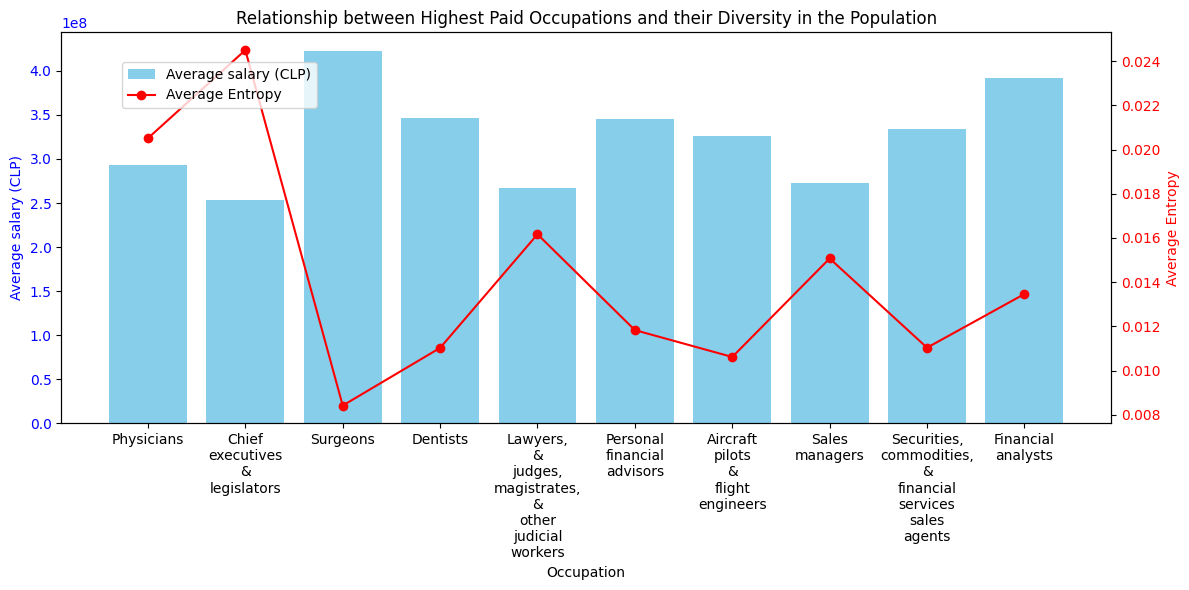

In [24]:
# Group by 'highest_paid_occupation'
occupation_stats = final_df.groupby("highest_paid_occupation").agg(
    total_population=("total_population", "sum"),
    avg_entropy=("entropy", "mean"),
    avg_salary=("highest_local_avg_salary_CLP", "mean")
).reset_index()

#top 10
top_occupations = occupation_stats.sort_values("total_population", ascending=False).head(10)
top_occupations["highest_paid_occupation"] = top_occupations["highest_paid_occupation"].str.replace(" ", "\n", regex=True)

#Plot -------------------------------------
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart: average salary
ax1.bar(
    top_occupations["highest_paid_occupation"],
    top_occupations["avg_salary"],
    color="skyblue",
    label="Average salary (CLP)"
)
ax1.set_ylabel("Average salary (CLP)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_xlabel("Occupation")
ax1.set_title("Relationship between Highest Paid Occupations and their Diversity in the Population")

# Line chart: average entropy
ax2 = ax1.twinx()
ax2.plot(
    top_occupations["highest_paid_occupation"],
    top_occupations["avg_entropy"],
    color="red",
    marker="o",
    label="Average Entropy"
)
ax2.set_ylabel("Average Entropy", color="red")
ax2.tick_params(axis="y", labelcolor="red")

fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.setp(ax1.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor")
plt.tight_layout()
plt.show()


If our client has already considered the states to which it is most convenient to project themselves in the future, it would be good for them to get an idea of the occupations they can perform and how difficult it will be to opt for these positions. First, they should know that the Shannon entropy (very close to zero) warns us that very few people occupy these positions. This could discourage them, but at the same time, they could see it as a challenge. If they still intend to follow that path, they can be recommended some of the occupations presented, in particular those whose Shannon index is slightly higher, since a greater quota could be expected and, therefore, greater chances of achieving a position in that position. To give some examples, "Physicians" (in general, highly sought after if we look at the rest of the records), "Chief Executives & legislators", and "Lawyers, & judges, magistrates, & other judicial workers".


I hope that the information provided is helpful for making the right decisions or at least for a better understanding of the Puma labor market. If you are not lucky, you can always choose to join the competition, in which case **I will have more and better insights. See you!**